First importing the needed packages.

In [1]:
import numpy as np
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.set_theme()

2023-12-31 10:33:11.277225: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load test and train .npy files from data/processed
X_train = np.load('data/processed/X_train.npy')
X_test = np.load('data/processed/X_test.npy')
y_train = np.load('data/processed/y_train.npy')
y_test = np.load('data/processed/y_test.npy')

In [3]:
y_train.shape
X_train.shape

(24000, 200, 200, 3)


## Model

### Iteration 1

The CNN model is defined below. As this is a basic tutorial-type of CNN task, the architecture is also very simple, with a cookie-cutter type of model class.
Most of the code in the model was generated via ChatGPT. There are some basic convolutional layers mixed with Max Pooling after each convolution. The architecture is a typical "bottleneck" shape with decreasing output dimensions until the dense layers flatten the activations to a 1D array. The max pooling layer is downsampling (dimension-reducing) layer which picks up the **maximum value** (=most important features) from a particular pooling window, the size of which you can see defined below.



Adam's optimizer is a very common neural net optimizer with an equally common learning rate of 0.001. `categorical_crossentropy` is also a common choice for a multi-class loss function. Softmax is a good activation function for classification as it scales all values to be between 0 and 1 (similar to probabilities). 






It might turn out that the model does not work optimally with this configuration, and further model tuning should be done. However, as model optimization is not the aim of this tutorial notebook, it is left for later opportunities.

In [4]:
class CNN:
    def __init__(self, num_classes):
        self.model = Sequential()
        self.model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Conv2D(64, (3, 3), activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dense(num_classes, activation='softmax'))

        optimizer = Adam(learning_rate=0.001)
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        
    def train(self, X_train, y_train, X_test, y_test, epochs=10, batch_size=32):
        return self.model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

Below we initialize the model and visualize its contents. The summary shows all the layers and the data output shapes after each layer.

In [5]:
model = CNN(y_test.shape[1])
model.model.summary()

/Users/rasmus.siljander/opt/anaconda3/envs/shape_recognition/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)      │        896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)        │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 147456)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 128)               │ 18,874,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 3)                 │        387 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 18,894,275 (72.08 MB)

 Trainable params: 18,894,275 (72.08 MB)

 Non-trainable params: 0 (0.00 B)

Next we train the model. We allow for default batch sizes (the size of data is so small the batch sizes are not that important here, but could be relevant for more computationally intensive models), and 10 epochs as a good starting point. To start, lets fit the model with only half of the training data for slightly faster training.

In [6]:
data_size = int(len(X_train)*0.5)
batch_size = int(data_size/100)

random_indices = np.random.choice(len(X_train), size=data_size, replace=False)

history = model.train(X_train[random_indices], y_train[random_indices], X_test, y_test, epochs=10, batch_size=50)

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 145s 597ms/step - accuracy: 0.3979 - loss: 1.7503 - val_accuracy: 0.5480 - val_loss: 0.9425
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 121s 502ms/step - accuracy: 0.5838 - loss: 0.8865 - val_accuracy: 0.6100 - val_loss: 0.8085
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 120s 500ms/step - accuracy: 0.7252 - loss: 0.6231 - val_accuracy: 0.6862 - val_loss: 0.6967
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 121s 502ms/step - accuracy: 0.8462 - loss: 0.3959 - val_accuracy: 0.7250 - val_loss: 0.6936
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 120s 500ms/step - accuracy: 0.9326 - loss: 0.2042 - val_accuracy: 0.7152 - val_loss: 0.8021
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 120s 500ms/step - accuracy: 0.9675 - loss: 0.1079 - val_accuracy: 0.7393 - val_loss: 0.9652
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 120s 499ms/step - accuracy: 0.9847 - loss: 0.0638 - val_accuracy: 0.7252 - val_loss: 1.0284
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 120s 499ms/step - accuracy: 0.9898 -

### Validation and analysis

Based on the trianing metrics above, the model seems to be quite clearly overfitting - training accuracy increases to be very high while validation accuracy lags behind. This can be confirmed with the error plots below, showing that in fact validation error starts increasing with increasing number of epochs.

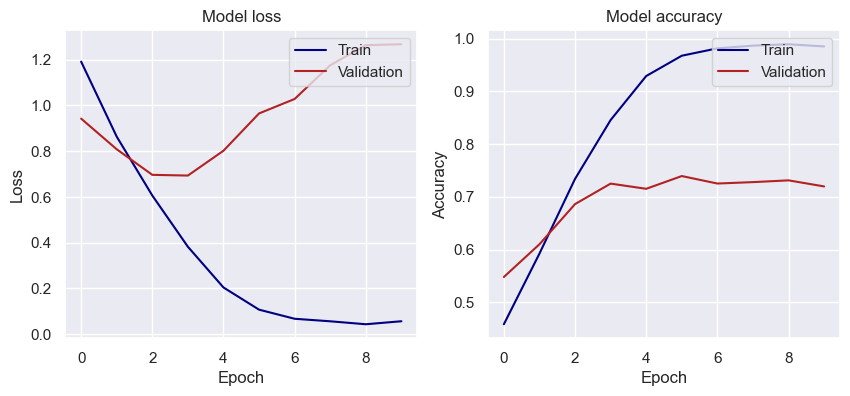

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot loss
ax[0].plot(history.history['loss'], color="navy")
ax[0].plot(history.history['val_loss'], color="firebrick")
ax[0].set_title('Model loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')

# Plot accuracy
ax[1].plot(history.history['accuracy'], color="navy")
ax[1].plot(history.history['val_accuracy'], color="firebrick")
ax[1].set_title('Model accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper right')

plt.show()

### Re-training with regularization

We can use several techniques to try to avoid this, including data augmentation, dropouts, early stopping, regularization, and batch normalization. Further, we can increase the amount of training data. Of these, dropouts, batch normalization, and early stopping are very easy to implement. Therefore, we can test how the model performs with these implementations. We will drop out 0.2 (20%) or neurons as it is a typical and quite conservative value for a dropout rate. Lets also define a possibility of early stopping.

Below is the same model with the aforementioned techniques implemented.

In [8]:
class CNN:
    def __init__(self, num_classes):
        self.model = Sequential()
        self.model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.2))

        self.model.add(Conv2D(64, (3, 3), activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.2))

        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(num_classes, activation='softmax'))

        optimizer = Adam(learning_rate=0.001)
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        
    def train(self, X_train, y_train, X_test, y_test, epochs=10, batch_size=32, early_stopping_rounds=None):
        if early_stopping_rounds:
            early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_rounds)
            return self.model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])
        else:
            return self.model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

In [9]:
model1 = CNN(y_test.shape[1])
model1.model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 198, 198, 32)      │        896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 99, 99, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 99, 99, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ (None, 97, 97, 64)        │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 48, 48, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 147456)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 128)               │ 18,874,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 3)                 │        387 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 18,894,275 (72.08 MB)

 Trainable params: 18,894,275 (72.08 MB)

 Non-trainable params: 0 (0.00 B)

Lets also use early stopping with patience of two epochs (we only train for 10). Lets also now use the full data now that we have established that the model works quite well.

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

history1 = model1.train(X_train, y_train, X_test, y_test, epochs=20, batch_size=100, early_stopping_rounds=2)

Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.3419 - loss: 2.3836 - val_accuracy: 0.4448 - val_loss: 1.0371
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 235s 974ms/step - accuracy: 0.4304 - loss: 1.0329 - val_accuracy: 0.4328 - val_loss: 1.0230
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 234s 974ms/step - accuracy: 0.4596 - loss: 1.0107 - val_accuracy: 0.5107 - val_loss: 0.9653
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 233s 970ms/step - accuracy: 0.4897 - loss: 0.9732 - val_accuracy: 0.5130 - val_loss: 0.9491
Epoch 5/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 232s 965ms/step - accuracy: 0.5176 - loss: 0.9409 - val_accuracy: 0.5485 - val_loss: 0.9169
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 232s 964ms/step - accuracy: 0.5604 - loss: 0.8918 - val_accuracy: 0.5783 - val_loss: 0.8599
Epoch 7/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 232s 964ms/step - accuracy: 0.6076 - loss: 0.8057 - val_accuracy: 0.6742 - val_loss: 0.7154
Epoch 8/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 232s 964ms/step - accuracy: 0.7300 - lo

In [11]:
# Lets save the model
model1.model.save('models/cnn.keras')

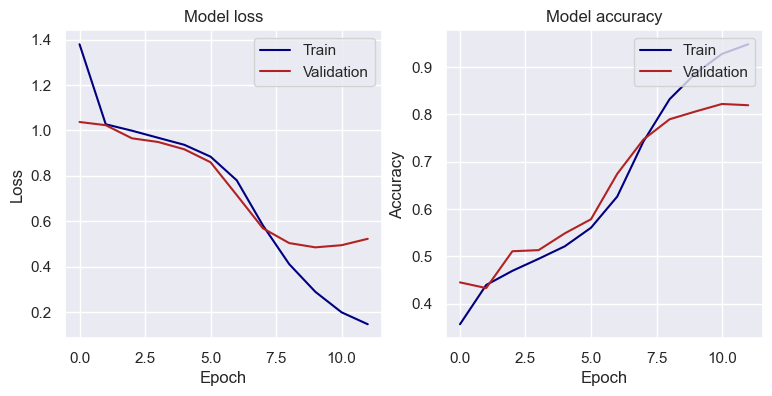

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Plot loss
ax[0].plot(history1.history['loss'], color="navy")
ax[0].plot(history1.history['val_loss'], color="firebrick")
ax[0].set_title('Model loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')

# Plot accuracy
ax[1].plot(history1.history['accuracy'], color="navy")
ax[1].plot(history1.history['val_accuracy'], color="firebrick")
ax[1].set_title('Model accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper right')

plt.show()

Here the learning curves are more in line. During the last epoch some overfitting seems to start happening, but the curves are still very similar to each other. Perhaps leaving out the last epoch could have been a useful choice, but its still enought for this tutorial.

The interesting feature is that most throughout the training, the model seems to perform better on the validation set than it does on the training set. Its not exactly sure why this happens, but one explanation could be that the distributions in the training and validation sets are slightly different, as seen in `data_processing.ipynb`. However, the differences are very small, and not reason for significant changes in design.

### Example test cases

Lets pick four shapes at random and see their predictions:

In [13]:
np.random.seed(3)

# Select 4 random indices from X_test
random_indices = np.random.choice(len(X_test), size=4, replace=False)

# Get the corresponding examples from X_test and y_test
random_X_test = X_test[random_indices]
random_y_test = y_test[random_indices]

# Print the random examples
print(random_y_test)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


And below mapping to what each ground truth vector means.

In [14]:
mapping = {
    "Circle": [1., 0., 0.],
    "Square": [0., 1., 0.],
    "Triangle": [0., 0., 1.]
}
shapes = ["Circle", "Square", "Triangle"]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
[3.1710067e-06 9.8725095e-06 9.9998701e-01]
Predicted: Triangle
Actual: Triangle

[5.1726823e-07 1.6679337e-02 9.8332018e-01]
Predicted: Triangle
Actual: Triangle

[5.1399606e-05 5.8685422e-01 4.1309434e-01]
Predicted: Square
Actual: Triangle

[7.1286273e-01 2.8689191e-01 2.4535091e-04]
Predicted: Circle
Actual: Circle



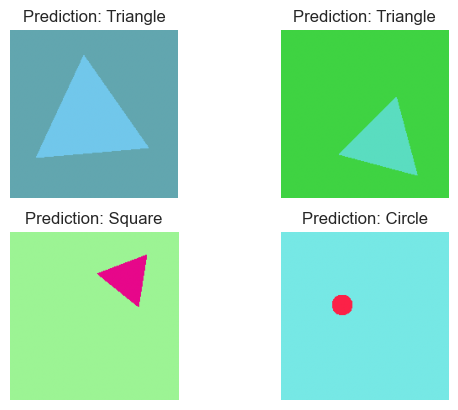

In [15]:
fig, axs = plt.subplots(2,2)

predictions = model1.model.predict(random_X_test)
for i in range(len(random_X_test)):
    prediction = predictions[i]
    print(prediction)

    predicted_label = shapes[np.argmax(prediction)]
    print(f"Predicted: {predicted_label}")

    actual_label = shapes[np.argmax(random_y_test[i])]
    print(f"Actual: {actual_label}")
    print()
    axs[i//2, i%2].imshow(random_X_test[i])
    axs[i//2, i%2].set_title(f"Prediction: {predicted_label}")
    axs[i//2, i%2].axis('off')

plt.show()


We can see that of the four example, two were correctly predicted. In the prediction arrays above we can also see the output activations for each of the categories for that test example. 
These activations can be approximately interpreted as the confidence that the model has in its predictions. 
From this, we see that during the cases that the model was correct, the model was very confident, but in the incorrect cases the model had a more difficult time in choosing between two options. 
It is also evident that the model got larger shapes correct more easily, but tended to miss smaller shapes.
It is therefore possible that the model failed to pick up on the fine-grain details of smaller shapes, something that *could possibly* be fixed by adding more detail to the model via more CNN layers (the two conv-layer configuration could have been too simplistic, but this is just speculation).

Furhter, since the error curves have not yet plateaued, it is possible that longer training times could lead to better performance, especially considering the heavy-ish overfitting techniques that we implemented into the data. Comparing the drop in training accuracy when compared to previous iterations, it could be that the model has not finished learning yet.

### Confusion matrix

Finally lets visualize a confusion matrix for a closer breakdown of classification performance.
By analyzing the confusion matrix, you can gain insights into the strengths and weaknesses of the model's classification performance. You can identify which classes are being misclassified more frequently and take steps to improve the model's accuracy for those classes.

188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step


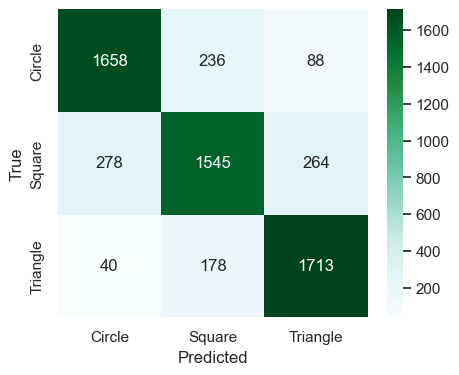

In [16]:
# Get the predicted labels for the test data
y_pred = model1.model.predict(X_test)

# calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuGn', xticklabels=shapes, yticklabels=shapes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


We see that most of the predictions are correct. Of the shapes, it seems that the square is the most difficult to predict, as there are more mis-classified squares. This could be due to squares being the least presented shape in the training data, as seen in `data_processing.ipynb`.

However, the amount of mistakes is quite low, and the model performance is overall quite good, with accuracy of about 80%. To imporove the model, I suggest longer training times combined with better regularization and a better balance between training and testing set. Still, however, the model seems to have converged enough to be able to generalize simple shape classification tasks, and is hence useful for playing around with simplistic shapes, **given that you want to classify only circles, triangles or sqaures** :).